In [1]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timezone
from pathlib import Path
import logging
import joblib 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json 

# --- Logging Setup ---
logger = logging.getLogger("training_logreg_per_minute") # Changed logger name slightly
if not logger.handlers:
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s.%(funcName)s:%(lineno)d - %(message)s')
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    logger.addHandler(ch)
else:
    logger.setLevel(logging.INFO)

# --- Directories ---
BASE_PROJECT_DIR = Path("/Users/omarabul-hassan/Desktop/projects/kalshi")
NOTEBOOKS_DIR = BASE_PROJECT_DIR / "notebooks"
FEATURES_DIR = NOTEBOOKS_DIR / "features"
TRAINED_MODELS_OUTPUT_DIR = NOTEBOOKS_DIR / "trained_models" / "logreg_per_minute" # New subdir for this model type

TRAINED_MODELS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Features expected from: {FEATURES_DIR}")
logger.info(f"Trained models (per-minute) will be saved to: {TRAINED_MODELS_OUTPUT_DIR}")

# --- Constants for Train/Test Split (based on market RESOLUTION time) ---
TRAIN_END_DATE_STR = "2025-05-08" 
TEST_START_DATE_STR = "2025-05-09" 
TEST_END_DATE_STR = "2025-05-15"   

TRAIN_UPTO_TS = int(dt.datetime.strptime(TRAIN_END_DATE_STR + " 23:59:59", "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp())
TEST_FROM_TS = int(dt.datetime.strptime(TEST_START_DATE_STR + " 00:00:00", "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp())
TEST_UPTO_TS = int(dt.datetime.strptime(TEST_END_DATE_STR + " 23:59:59", "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp())

logger.info(f"Training data: Market resolutions up to {TRAIN_END_DATE_STR} (ts: {TRAIN_UPTO_TS})")
logger.info(f"Testing data: Market resolutions from {TEST_START_DATE_STR} (ts: {TEST_FROM_TS}) to {TEST_END_DATE_STR} (ts: {TEST_UPTO_TS})")

logger.info("Cell 1: Setup complete.")

2025-05-22 17:32:46,368 - INFO - training_logreg_per_minute.<module>:38 - Features expected from: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features
2025-05-22 17:32:46,369 - INFO - training_logreg_per_minute.<module>:39 - Trained models (per-minute) will be saved to: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute
2025-05-22 17:32:46,369 - INFO - training_logreg_per_minute.<module>:50 - Training data: Market resolutions up to 2025-05-08 (ts: 1746748799)
2025-05-22 17:32:46,370 - INFO - training_logreg_per_minute.<module>:51 - Testing data: Market resolutions from 2025-05-09 (ts: 1746748800) to 2025-05-15 (ts: 1747353599)
2025-05-22 17:32:46,370 - INFO - training_logreg_per_minute.<module>:53 - Cell 1: Setup complete.


In [2]:
# Cell 2: Load Features (MODIFIED)

# Find the latest "per-minute decision features" CSV file
# This uses the new filename pattern from the revised feature_engineering.ipynb
list_of_feature_files = sorted(
    glob.glob(str(FEATURES_DIR / "kalshi_per_minute_decision_features_*.csv")), # MODIFIED pattern
    key=os.path.getctime,
    reverse=True 
)

if not list_of_feature_files:
    logger.critical(f"CRITICAL: No 'per_minute_decision_features' CSV files found in {FEATURES_DIR}.")
    raise FileNotFoundError(f"No 'per_minute_decision_features' CSV files found. Ensure new feature_engineering.ipynb has run.")
else:
    # Use the specific file you mentioned if you want to lock it, otherwise use latest
    # LATEST_FEATURES_CSV_PATH = Path("/Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_per_minute_decision_features_20250522_172347.csv")
    LATEST_FEATURES_CSV_PATH = Path(list_of_feature_files[0]) # Or hardcode if preferred for reproducibility
    
    logger.info(f"Loading PER-MINUTE features from: {LATEST_FEATURES_CSV_PATH}")
    try:
        features_df = pd.read_csv(LATEST_FEATURES_CSV_PATH, low_memory=False)
        logger.info(f"Loaded PER-MINUTE features DataFrame with {features_df.shape[0]} rows and {features_df.shape[1]} columns.")
        
        # Essential columns for this new structure
        essential_cols = ['market_ticker', 'decision_timestamp_s', 'resolution_time_ts', 'target']
        if any(col not in features_df.columns for col in essential_cols):
            missing = [col for col in essential_cols if col not in features_df.columns]
            logger.critical(f"Essential columns ({missing}) not found in features DataFrame.")
            raise ValueError(f"Features DataFrame missing essential columns: {missing}")
        
        # Optional: Display info or head for a quick check
        # logger.info(features_df.info())
        # display(features_df.head())
            
    except Exception as e:
        logger.critical(f"Error loading features CSV {LATEST_FEATURES_CSV_PATH}: {e}", exc_info=True)
        raise

logger.info("Cell 2: Per-minute feature loading complete.")

2025-05-22 17:32:46,375 - INFO - training_logreg_per_minute.<module>:19 - Loading PER-MINUTE features from: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/features/kalshi_per_minute_decision_features_20250522_172347.csv
2025-05-22 17:32:49,142 - INFO - training_logreg_per_minute.<module>:22 - Loaded PER-MINUTE features DataFrame with 1286808 rows and 25 columns.
2025-05-22 17:32:49,143 - INFO - training_logreg_per_minute.<module>:39 - Cell 2: Per-minute feature loading complete.


In [3]:
# Cell 3: Data Preprocessing and Feature Selection (SIGNIFICANTLY MODIFIED)

if 'features_df' not in locals() or features_df.empty: 
    logger.error("Features DataFrame is empty or not loaded. Cannot proceed.")
    X, y, processed_df, MODEL_FEATURE_NAMES = pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame(), [] 
else:
    # --- 1. Define Feature Columns for the Per-Minute Model ---
    # These are the new features generated by the revised feature_engineering.ipynb
    # Exclude identifiers (market_ticker, decision_timestamp_s, resolution_time_ts) and the target.
    
    MODEL_FEATURE_NAMES = [
        'strike_price',
        'time_to_resolution_minutes',
        'current_btc_price',
        'current_dist_strike_abs',
        'current_dist_strike_pct',
        # Add lag features
        'btc_price_change_pct_1m', 'btc_price_change_pct_3m', 'btc_price_change_pct_5m',
        'btc_price_change_pct_10m', 'btc_price_change_pct_15m', 'btc_price_change_pct_30m',
        # Add volatility features
        'btc_volatility_5m', 'btc_volatility_15m', 'btc_volatility_30m',
        # Add current Kalshi market state features
        'current_kalshi_yes_bid', 'current_kalshi_yes_ask', 'current_kalshi_mid_price',
        'current_kalshi_spread_abs', 'current_kalshi_spread_pct',
        'current_kalshi_volume', 'current_kalshi_oi'
    ]
    
    # Verify that all selected feature names actually exist in the loaded DataFrame
    actual_columns_in_df = features_df.columns.tolist()
    missing_model_features = [name for name in MODEL_FEATURE_NAMES if name not in actual_columns_in_df]
    if missing_model_features:
        logger.critical(f"CRITICAL: The following selected MODEL_FEATURE_NAMES are MISSING from the loaded features_df: {missing_model_features}")
        logger.critical(f"Available columns in features_df: {actual_columns_in_df}")
        raise ValueError("Selected model features are not present in the loaded data.")
    
    logger.info(f"Selected {len(MODEL_FEATURE_NAMES)} features for the per-minute model.")
    logger.info(f"Selected features: {MODEL_FEATURE_NAMES}")

    # --- 2. Handle Missing Values (NaNs) for SELECTED FEATURES ---
    processed_df = features_df.copy() # Work on a copy
    
    # Impute NaNs ONLY in the columns we've selected for MODEL_FEATURE_NAMES
    for col in MODEL_FEATURE_NAMES:
        if processed_df[col].isnull().any(): 
            median_val = processed_df[col].median()
            if pd.isna(median_val): 
                logger.warning(f"Median for selected feature '{col}' is NaN. Filling with 0 as a fallback.")
                processed_df[col].fillna(0, inplace=True) 
            else:
                processed_df[col].fillna(median_val, inplace=True)
    
    # --- Define X (features) and y (target) ---
    X = processed_df[MODEL_FEATURE_NAMES]
    y = processed_df['target']

    # Final NaN check on X
    if X.isnull().sum().sum() > 0:
        logger.warning(f"NaNs still present in X after imputation. This is unexpected for median imputation unless medians were also NaN and not handled by fallback.")
        logger.warning(f"Columns with NaNs: \n{X.isnull().sum()[X.isnull().sum() > 0]}")
        logger.info("Dropping rows with any remaining NaNs in X for robust training.")
        nan_rows_mask = X.isnull().any(axis=1)
        X = X[~nan_rows_mask]
        y = y[~nan_rows_mask] # Crucial: Align y with X
        logger.info(f"New X shape after dropping NaN rows: {X.shape}")
    else:
        logger.info("Median imputation for selected features complete. No NaNs remaining in X.")

    logger.info(f"Shape of X (features): {X.shape}")
    logger.info(f"Shape of y (target): {y.shape}")
    if not y.empty:
        logger.info(f"Target value counts:\n{y.value_counts(normalize=True)}")
    
    if not X.empty:
        display(X.head())
    else:
        logger.warning("Feature set X is empty after selection/preprocessing.")

    # We also need `processed_df` to contain `MODEL_FEATURE_NAMES` and `target` for the split,
    # and `resolution_time_ts` for filtering. So, ensure `processed_df` also reflects dropped rows if `X.dropna` was used.
    # If X was modified by dropping rows, processed_df needs to be re-aligned.
    # Assuming X and y are now aligned:
    # processed_df = processed_df.loc[X.index] # Re-align processed_df to match X and y
    # This is tricky if X.dropna() was used. Simpler: ensure processed_df passed to split has clean features.
    # The split cell will use `processed_df_for_split` which is a copy of the `processed_df` from *this cell*.
    # If X had rows dropped, `processed_df` here needs to reflect that for the split mask to align.
    # Let's ensure 'processed_df' contains the final X and y indices for the split
    if X.shape[0] < len(features_df): # if rows were dropped from X
         processed_df = processed_df.loc[X.index] # Align processed_df with the cleaned X
         logger.info(f"Aligned 'processed_df' with cleaned X. New processed_df shape: {processed_df.shape}")

2025-05-22 17:32:49,151 - INFO - training_logreg_per_minute.<module>:36 - Selected 21 features for the per-minute model.
2025-05-22 17:32:49,151 - INFO - training_logreg_per_minute.<module>:37 - Selected features: ['strike_price', 'time_to_resolution_minutes', 'current_btc_price', 'current_dist_strike_abs', 'current_dist_strike_pct', 'btc_price_change_pct_1m', 'btc_price_change_pct_3m', 'btc_price_change_pct_5m', 'btc_price_change_pct_10m', 'btc_price_change_pct_15m', 'btc_price_change_pct_30m', 'btc_volatility_5m', 'btc_volatility_15m', 'btc_volatility_30m', 'current_kalshi_yes_bid', 'current_kalshi_yes_ask', 'current_kalshi_mid_price', 'current_kalshi_spread_abs', 'current_kalshi_spread_pct', 'current_kalshi_volume', 'current_kalshi_oi']
/var/folders/43/br9zl9l149d3rb94gdkr1wsm0000gn/T/ipykernel_26950/2927200956.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.

,strike_price,time_to_resolution_minutes,current_btc_price,current_dist_strike_abs,current_dist_strike_pct,btc_price_change_pct_1m,btc_price_change_pct_3m,btc_price_change_pct_5m,btc_price_change_pct_10m,btc_price_change_pct_15m,...,btc_volatility_5m,btc_volatility_15m,btc_volatility_30m,current_kalshi_yes_bid,current_kalshi_yes_ask,current_kalshi_mid_price,current_kalshi_spread_abs,current_kalshi_spread_pct,current_kalshi_volume,current_kalshi_oi
0,106249.99,59.0,103785.66,-2464.33,-0.023194,0.000738,0.000444,0.000802,0.000076,-0.001098,...,30.572030,79.377628,113.561892,0.0,0.3,0.15,0.3,2.0,0.0,0.0
1,106249.99,58.0,103691.25,-2558.74,-0.024082,-0.000910,-0.000709,-0.000332,0.000057,-0.002193,...,38.773055,69.408713,115.612955,0.0,0.3,0.15,0.3,2.0,0.0,0.0
2,106249.99,57.0,103629.36,-2620.63,-0.024665,-0.000597,-0.000769,-0.001062,-0.000949,-0.002921,...,62.051566,55.815136,121.618868,0.0,0.3,0.15,0.3,2.0,0.0,0.0
3,106249.99,56.0,103619.99,-2630.00,-0.024753,-0.000090,-0.001596,-0.001396,-0.000690,-0.002067,...,67.180637,55.082336,126.305198,0.0,0.3,0.15,0.3,2.0,0.0,0.0
4,106249.99,55.0,103622.60,-2627.39,-0.024728,0.000025,-0.000662,-0.000834,-0.000664,-0.001908,...,71.112425,52.244428,126.704856,0.0,0.3,0.15,0.3,2.0,0.0,0.0


In [4]:
# Cell 4: Time-Based Train-Test Split (MODIFIED)

if 'processed_df' not in locals() or processed_df.empty or 'X' not in locals() or X.empty:
    logger.error("processed_df or X is not available or empty from Cell 3. Cannot split.")
    X_train, y_train, X_test, y_test, test_identifiers_df = pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()
else:
    # `processed_df` from Cell 3 already has MODEL_FEATURE_NAMES (imputed) and 'target'.
    # It also has 'resolution_time_ts', 'market_ticker', 'decision_timestamp_s'.
    
    # Ensure 'resolution_time_ts' is numeric for filtering
    if 'resolution_time_ts' not in processed_df.columns:
        raise ValueError("'resolution_time_ts' column is missing from processed_df for splitting.")
    processed_df['resolution_time_ts'] = pd.to_numeric(processed_df['resolution_time_ts'], errors='coerce')
    
    # Drop rows where resolution_time_ts could not be parsed (should be rare if data is clean)
    initial_rows_before_ts_dropna = len(processed_df)
    processed_df.dropna(subset=['resolution_time_ts'], inplace=True)
    if len(processed_df) < initial_rows_before_ts_dropna:
        logger.warning(f"Dropped {initial_rows_before_ts_dropna - len(processed_df)} rows due to NaN in 'resolution_time_ts' for splitting.")
        # If rows were dropped here, X and y also need to be re-aligned from this new processed_df
        X = processed_df[MODEL_FEATURE_NAMES]
        y = processed_df['target']
        logger.info(f"Re-aligned X and y after 'resolution_time_ts' NaN drop. New X shape: {X.shape}")


    # Training set: all decision points for markets resolving up to TRAIN_UPTO_TS
    train_mask = (processed_df['resolution_time_ts'] <= TRAIN_UPTO_TS)
    
    # Testing set: all decision points for markets resolving between TEST_FROM_TS and TEST_UPTO_TS
    test_mask = (processed_df['resolution_time_ts'] >= TEST_FROM_TS) & \
                  (processed_df['resolution_time_ts'] <= TEST_UPTO_TS)

    # Apply mask to the feature set X and target y
    X_train = X[train_mask]
    y_train = y[train_mask]
    
    X_test = X[test_mask]
    y_test = y[test_mask]

    # Store test set identifiers, now including decision_timestamp_s
    test_identifiers_df = processed_df[test_mask][['market_ticker', 'decision_timestamp_s', 'resolution_time_ts', 'strike_price']].copy()

    logger.info(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    logger.info(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    if X_train.empty or X_test.empty:
        logger.critical("Training or testing set is empty after time-based split! Check date ranges and data volume.")
        min_res_ts = processed_df['resolution_time_ts'].min()
        max_res_ts = processed_df['resolution_time_ts'].max()
        logger.info(f"Min resolution_time_ts in data: {dt.datetime.fromtimestamp(min_res_ts, tz=timezone.utc) if pd.notna(min_res_ts) else 'N/A'}")
        logger.info(f"Max resolution_time_ts in data: {dt.datetime.fromtimestamp(max_res_ts, tz=timezone.utc) if pd.notna(max_res_ts) else 'N/A'}")
        logger.info(f"TRAIN_UPTO_TS: {dt.datetime.fromtimestamp(TRAIN_UPTO_TS, tz=timezone.utc)}")
        logger.info(f"TEST_FROM_TS: {dt.datetime.fromtimestamp(TEST_FROM_TS, tz=timezone.utc)}")
        logger.info(f"TEST_UPTO_TS: {dt.datetime.fromtimestamp(TEST_UPTO_TS, tz=timezone.utc)}")
    else:
        logger.info(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
        logger.info(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")
        
        if X_train.isnull().sum().sum() > 0: logger.warning(f"NaNs found in X_train after split: {X_train.isnull().sum().sum()}")
        if X_test.isnull().sum().sum() > 0: logger.warning(f"NaNs found in X_test after split: {X_test.isnull().sum().sum()}")

2025-05-22 17:32:49,408 - INFO - training_logreg_per_minute.<module>:43 - X_train shape: (960025, 21), y_train shape: (960025,)
2025-05-22 17:32:49,408 - INFO - training_logreg_per_minute.<module>:44 - X_test shape: (323066, 21), y_test shape: (323066,)
2025-05-22 17:32:49,412 - INFO - training_logreg_per_minute.<module>:56 - Training target distribution:
target
1    0.517021
0    0.482979
Name: proportion, dtype: float64
2025-05-22 17:32:49,415 - INFO - training_logreg_per_minute.<module>:57 - Testing target distribution:
target
1    0.503362
0    0.496638
Name: proportion, dtype: float64


In [5]:
# Cell 5: Model Training (Logistic Regression)

if 'X_train' not in locals() or X_train.empty:
    logger.error("X_train is not available or empty. Cannot train model.")
else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    if not X_test.empty:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = np.array([]) 
        logger.warning("X_test is empty, X_test_scaled will be empty. Evaluation might not be possible.")
    
    logger.info("Numeric features scaled using StandardScaler.")

    logreg_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', C=1.0, max_iter=1000) # Added max_iter
    
    logger.info(f"Training Logistic Regression model on {X_train_scaled.shape[0]} samples...")
    logreg_model.fit(X_train_scaled, y_train)
    logger.info("Model training complete.")

    scaler_filename = "logreg_per_minute_scaler.joblib" # New naming
    model_filename = "logreg_per_minute_model.joblib"   # New naming
    feature_names_filename = "logreg_per_minute_feature_names.json" 

    try:
        joblib.dump(scaler, TRAINED_MODELS_OUTPUT_DIR / scaler_filename)
        logger.info(f"Scaler saved to {TRAINED_MODELS_OUTPUT_DIR / scaler_filename}")
        
        joblib.dump(logreg_model, TRAINED_MODELS_OUTPUT_DIR / model_filename)
        logger.info(f"Model saved to {TRAINED_MODELS_OUTPUT_DIR / model_filename}")

        if 'MODEL_FEATURE_NAMES' in locals() and MODEL_FEATURE_NAMES:
            with open(TRAINED_MODELS_OUTPUT_DIR / feature_names_filename, 'w') as f:
                json.dump(MODEL_FEATURE_NAMES, f)
            logger.info(f"Feature names used for model saved to {TRAINED_MODELS_OUTPUT_DIR / feature_names_filename}")
        else:
            logger.warning("MODEL_FEATURE_NAMES not defined or empty. Not saving feature names list.")

    except Exception as e:
        logger.error(f"Error saving model or scaler: {e}", exc_info=True)

2025-05-22 17:32:49,593 - INFO - training_logreg_per_minute.<module>:15 - Numeric features scaled using StandardScaler.
2025-05-22 17:32:49,593 - INFO - training_logreg_per_minute.<module>:19 - Training Logistic Regression model on 960025 samples...
2025-05-22 17:32:52,844 - INFO - training_logreg_per_minute.<module>:21 - Model training complete.
2025-05-22 17:32:52,846 - INFO - training_logreg_per_minute.<module>:29 - Scaler saved to /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute/logreg_per_minute_scaler.joblib
2025-05-22 17:32:52,847 - INFO - training_logreg_per_minute.<module>:32 - Model saved to /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute/logreg_per_minute_model.joblib
2025-05-22 17:32:52,848 - INFO - training_logreg_per_minute.<module>:37 - Feature names used for model saved to /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute/logreg_per_minute_feature_n

2025-05-22 17:32:52,855 - INFO - training_logreg_per_minute.<module>:12 - Evaluating model on the test set (per-minute decision points)...
2025-05-22 17:32:52,914 - INFO - training_logreg_per_minute.<module>:20 - Test Set ROC AUC Score: 0.8431
2025-05-22 17:32:52,914 - INFO - training_logreg_per_minute.<module>:25 - Test Set Accuracy: 0.7534
2025-05-22 17:32:52,954 - INFO - training_logreg_per_minute.<module>:26 - 
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.71    160447
           1       0.70      0.88      0.78    162619

    accuracy                           0.75    323066
   macro avg       0.77      0.75      0.75    323066
weighted avg       0.77      0.75      0.75    323066



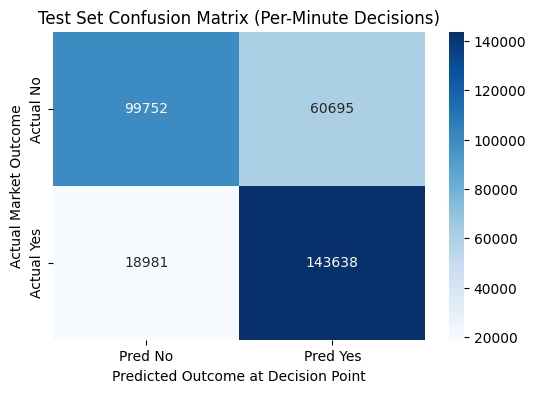

2025-05-22 17:32:53,765 - INFO - training_logreg_per_minute.<module>:57 - Test set (per-minute) predictions saved to: /Users/omarabul-hassan/Desktop/projects/kalshi/notebooks/trained_models/logreg_per_minute/logreg_per_minute_test_predictions_20250522_173253.csv


,market_ticker,decision_timestamp_s,resolution_time_ts,strike_price,actual_target,predicted_target_logreg,predicted_proba_yes_logreg,time_to_resolution_at_pred
3717,KXBTCD-25MAY1519-T105749.99,1747346460,1747350000,105749.99,0,0,0.154327,59.0
3718,KXBTCD-25MAY1519-T105749.99,1747346520,1747350000,105749.99,0,0,0.143886,58.0
3719,KXBTCD-25MAY1519-T105749.99,1747346580,1747350000,105749.99,0,0,0.143133,57.0
3720,KXBTCD-25MAY1519-T105749.99,1747346640,1747350000,105749.99,0,0,0.143440,56.0
3721,KXBTCD-25MAY1519-T105749.99,1747346700,1747350000,105749.99,0,0,0.140755,55.0


2025-05-22 17:32:53,767 - INFO - training_logreg_per_minute.<module>:60 - Cell 6: Model evaluation complete.


In [6]:
# Cell 6: Model Evaluation (MODIFIED)

model_ready = 'logreg_model' in locals()
test_data_available = ('X_test_scaled' in locals() and isinstance(X_test_scaled, np.ndarray) and X_test_scaled.size > 0 and \
                       'y_test' in locals() and not y_test.empty and \
                       'test_identifiers_df' in locals() and not test_identifiers_df.empty)


if not model_ready or not test_data_available:
    logger.error("Model not trained or test data (X_test_scaled, y_test, test_identifiers_df) not available/empty. Cannot evaluate.")
else:
    logger.info("Evaluating model on the test set (per-minute decision points)...")
    
    y_pred_test = logreg_model.predict(X_test_scaled)
    y_pred_proba_test = logreg_model.predict_proba(X_test_scaled)[:, 1] 

    accuracy = accuracy_score(y_test, y_pred_test)
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba_test)
        logger.info(f"Test Set ROC AUC Score: {roc_auc:.4f}")
    except ValueError as e:
        logger.warning(f"Could not calculate ROC AUC: {e}. This can happen if only one class is present in y_test.")
        roc_auc = np.nan # Or handle as needed
    
    logger.info(f"Test Set Accuracy: {accuracy:.4f}")
    logger.info("\nTest Set Classification Report:\n" + classification_report(y_test, y_pred_test, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.title('Test Set Confusion Matrix (Per-Minute Decisions)')
    plt.ylabel('Actual Market Outcome')
    plt.xlabel('Predicted Outcome at Decision Point')
    plt.show()

    # Store predictions with identifiers for backtesting analysis
    # test_identifiers_df already has 'market_ticker', 'decision_timestamp_s', 'resolution_time_ts', 'strike_price'
    # Ensure its index aligns with y_test for correct assignment if y_test was modified
    test_predictions_df = test_identifiers_df.copy()
    
    # Defensive check: if y_test or X_test (and thus test_identifiers_df) had rows dropped, 
    # their indices might not be continuous from 0.
    # It's safer to assign based on shared index if possible, or ensure order is maintained.
    # Assuming test_identifiers_df.index matches y_test.index (as they come from the same mask on processed_df)
    test_predictions_df['actual_target'] = y_test.values # .values to ignore index if y_test index is tricky
    test_predictions_df['predicted_target_logreg'] = y_pred_test
    test_predictions_df['predicted_proba_yes_logreg'] = y_pred_proba_test
    
    # Add time_to_resolution for context in predictions file
    if 'time_to_resolution_minutes' in X_test.columns:
         # X_test index should align with test_predictions_df index if created correctly
        test_predictions_df['time_to_resolution_at_pred'] = X_test['time_to_resolution_minutes'].values
    
    predictions_filename = f"logreg_per_minute_test_predictions_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    predictions_filepath = TRAINED_MODELS_OUTPUT_DIR / predictions_filename
    test_predictions_df.to_csv(predictions_filepath, index=False)
    logger.info(f"Test set (per-minute) predictions saved to: {predictions_filepath}")
    display(test_predictions_df.head())

logger.info("Cell 6: Model evaluation complete.")